In [24]:
from numpy import asarray
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, plot_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, MaxPool2D, Flatten, Dense
import glob
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

##Output Preprocessing

In [25]:
data = pd.read_csv("/content/drive/MyDrive/house_table.txt", header=None, sep = " ")
price = data.iloc[:,-1:] #Tablo verimizden fiyatları çekiyoruz

##Photo Input Preprocessing

In [26]:
input_images_list = []

In [27]:
for housepath in glob.glob('/content/drive/MyDrive/Houses/*.jpg'):
  image = cv2.imread(housepath) #verileri okuyoruz
  res_image = cv2.resize(image,(300,300),cv2.INTER_AREA) #verilerin pixellerini resize ediyoruz
  input_images_list.append(res_image) #verilerimizi input images'e ekliyoruz

 

In [28]:
input_images = np.array(input_images_list).reshape((535,4,300,300,3))
images_train, images_test, price_train, price_test = train_test_split(input_images , price, test_size=0.33, shuffle=False)

In [29]:
photo_bath = []
photo_bed = []
photo_front = []
photo_kitch = []

#fotoğrafları bölümlerine göre 4'e ayırdım ve yukarıda oluşturduğum boş listeye attım
for i in range(len(images_train)):
  photo_bath.append(images_train[i,0])
  photo_bed.append(images_train[i,1])
  photo_front.append(images_train[i,2])
  photo_kitch.append(images_train[i,3])

#..._train adında arraylere dönüştürdüm
bath_train = np.array(photo_bath)
bed_train = np.array(photo_bed)
front_train = np.array(photo_front)
kitch_train = np.array(photo_kitch)

##Table Input Preprocessing

In [30]:
table_data = pd.read_csv("/content/drive/MyDrive/house_table.txt", header=None, sep=" ")

price = table_data.iloc[:,-1]
info_house = table_data.iloc[:,:-1]

table_x_train, table_x_test, table_y_train, table_y_test = train_test_split(info_house,price, test_size=0.33, shuffle=False)

table_x_train = table_x_train.values
table_x_test = table_x_test.values

#Price_train adında array'e dönüştürdüm
price_train = table_y_train.values
price_test = table_y_test.values

#x_train ve x_test için sütünlara göre bölme işlemi
room_train, floors_train, m2_train, loc_train = np.transpose(table_x_train) 
room_test, floors_test, m2_test, loc_test = np.transpose(table_x_test)





In [31]:
m2_train.shape

(358,)

In [32]:
#table ve image verileri tek bir sözlük içinde topladım
x_train1 = {"input_room": room_train,"input_floors": floors_train,"input_m2":m2_train, "input_loc":loc_train, "bath" : bath_train, "bed" : bed_train, "front" : front_train, "kitch" : kitch_train }
x_train = [room_train,floors_train,m2_train,loc_train,bath_train, bed_train, kitch_train,front_train]


##MODEL

In [33]:

input_shape  = (1,)

input_room   = Input(shape=input_shape, name="input_room")
input_floors = Input(shape=input_shape, name="input_floors")
input_m2     = Input(shape=input_shape, name="input_m2")
input_loc    = Input(shape=input_shape, name="input_loc")

input_layer_table=[input_room,input_floors,input_m2,input_loc] #modele girecek tüm table inputlar
input_linear_list_table= [input_room,input_floors,input_m2] #lokasyon hariç diğer table inputları concate etmek için listede topluyorum
con_input_linear_list_table = Concatenate(axis=0)(input_linear_list_table) #lokasyon hariç diğer table inputları concate ediyorum




input_bath = Input(shape = (300,300,3),name="bath")
input_bed = Input(shape = (300,300,3),name="bed")
input_front = Input(shape = (300,300,3),name="front")
input_kitch = Input(shape = (300,300,3),name="kitch")

input_con_list = [input_bath,input_bed,input_kitch] #front hariç diğer image inputları concate etmek için listede topluyorum
input_con = tf.keras.layers.Concatenate(axis=0)(input_con_list) #front hariç diğer image inputları concate ediyorum
input_layer_image = [input_con_list,input_front] #Modele girecek tüm image inputlar

total_input_layer = [input_layer_table,input_layer_image] #modele girecek image ve table inputların tamamı

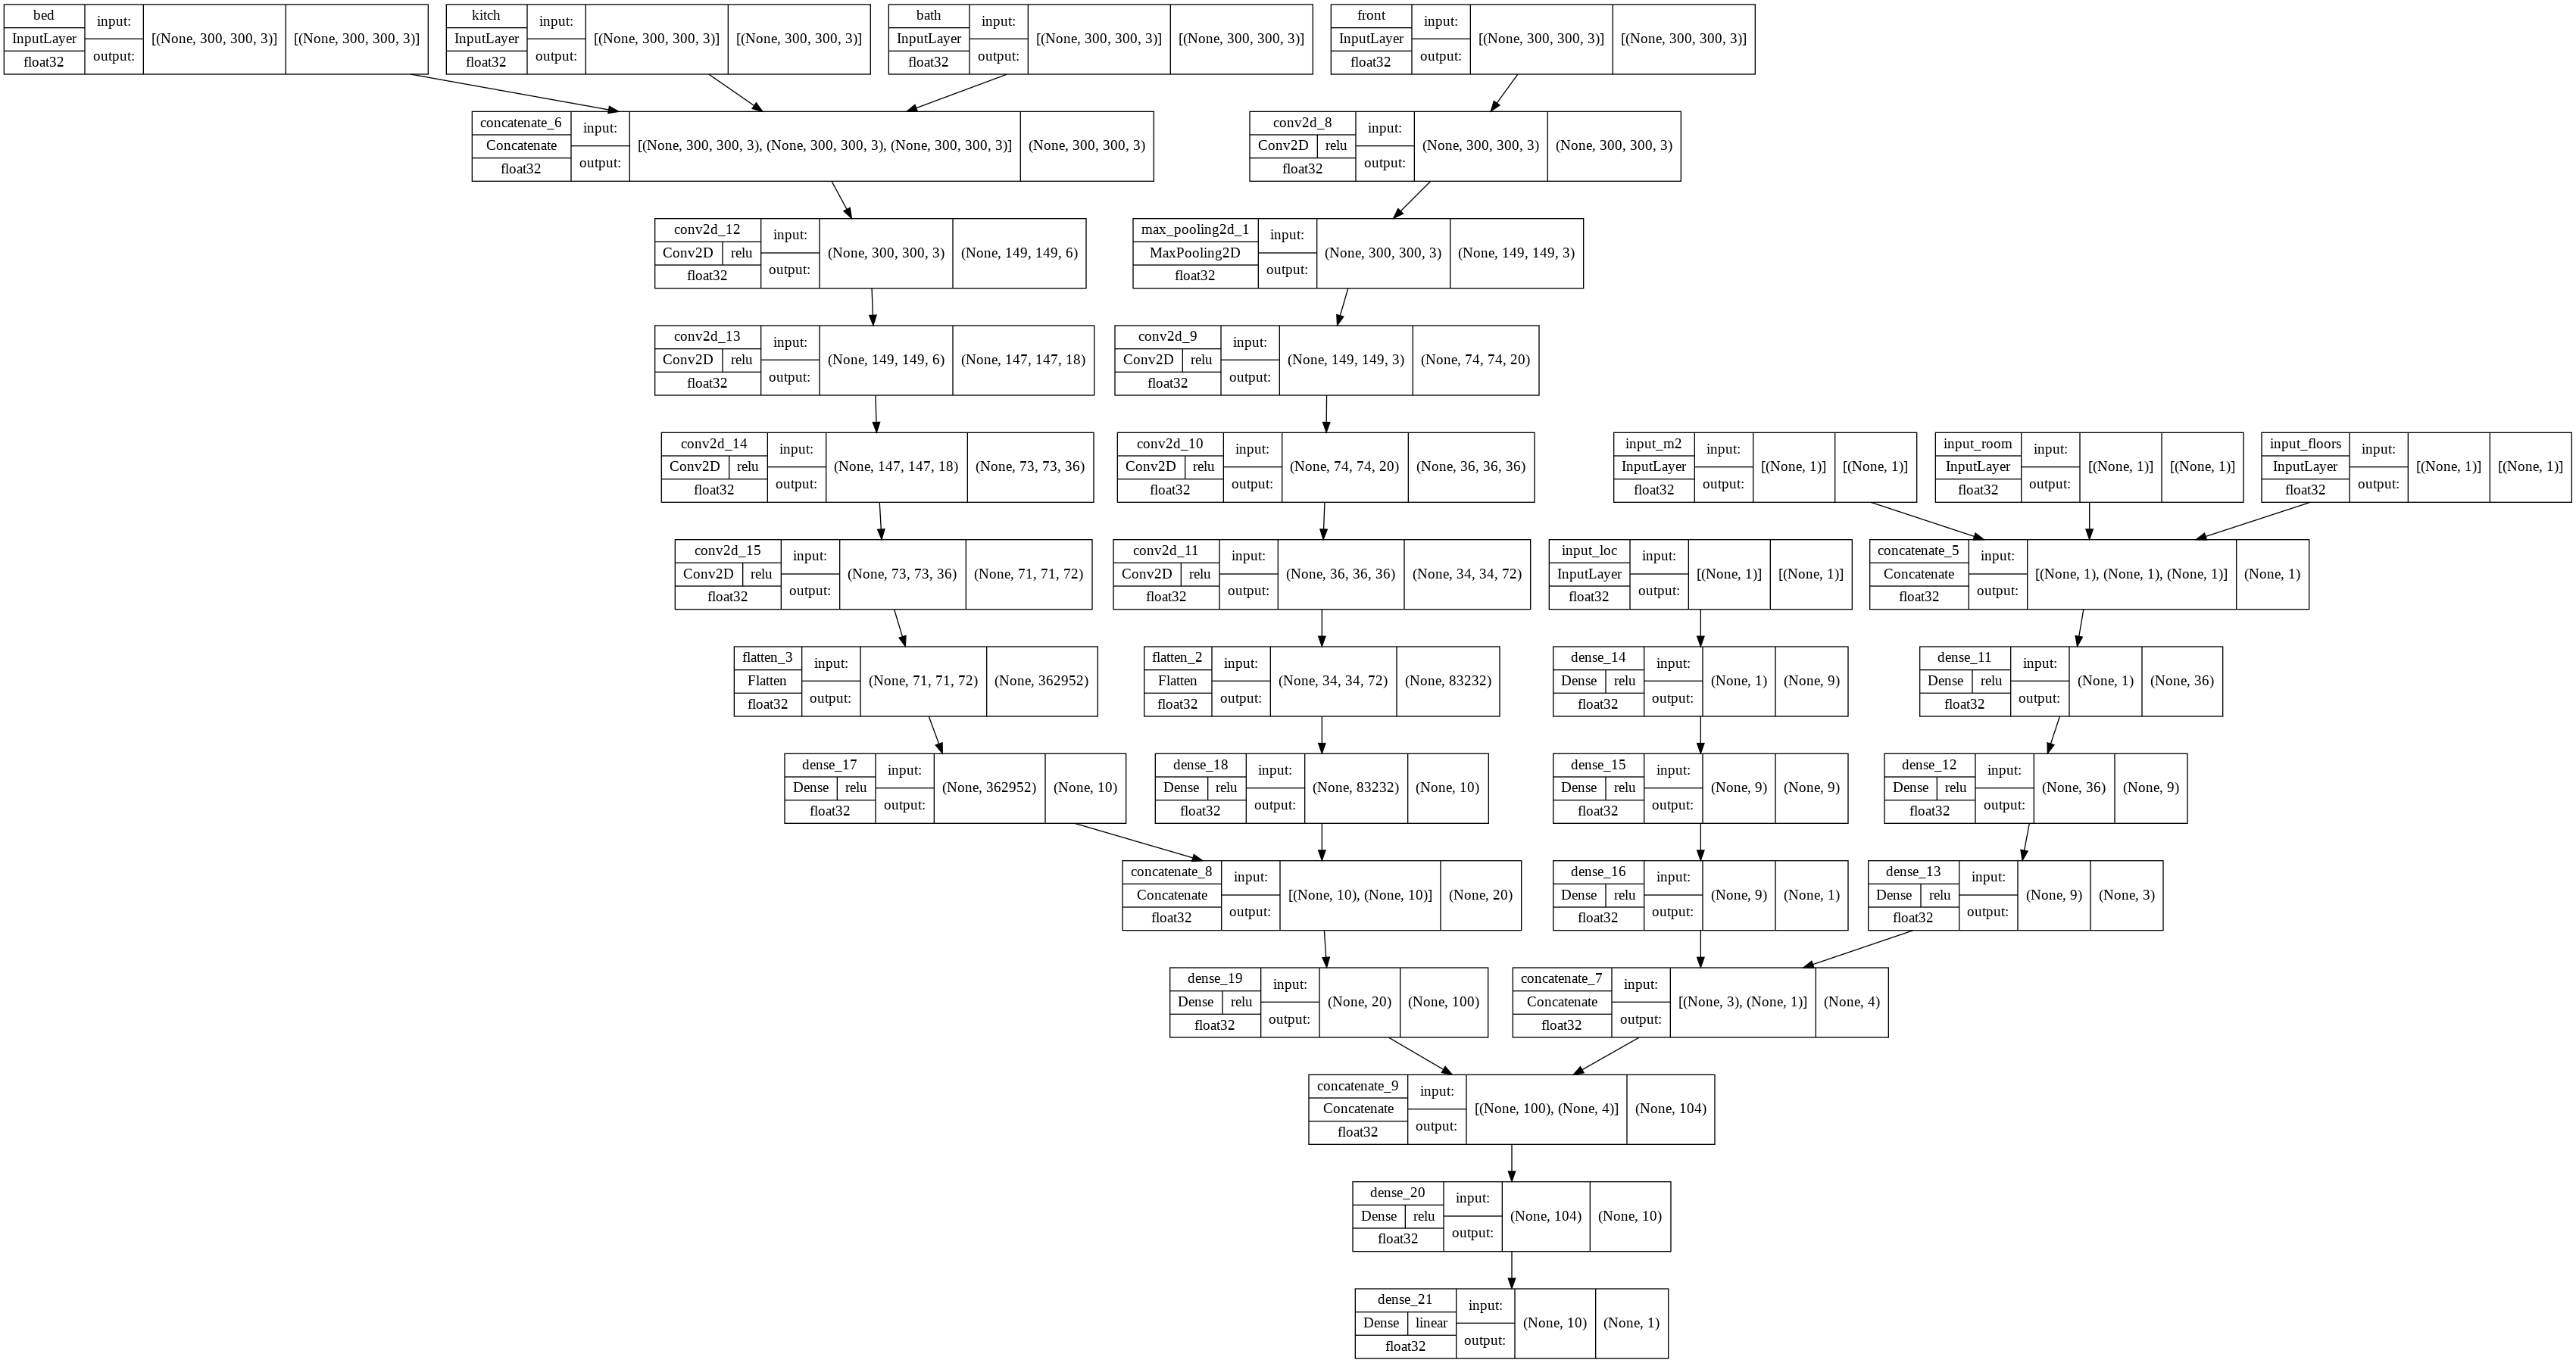

In [34]:
##TABLE 

l1_1 =  Dense(36,activation="relu")(con_input_linear_list_table)

l1_2 =  Dense(9,activation="relu")(l1_1)

l1_3 =  Dense(3,activation="relu")(l1_2)

l2_1 =  Dense(9,activation="relu")(input_loc)

l2_2 =  Dense(9,activation="relu")(l2_1)

l2_3 =  Dense(1,activation="relu")(l2_2)

con_table = Concatenate(axis=1)([l1_3,l2_3])


##İMAGES

l1_front = Conv2D(
    filters = 3,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'same', activation="relu")(input_front)

max_front = MaxPool2D(
    pool_size=(3, 3),
    strides=(2,2),
    padding='valid')(l1_front)



l2_front = Conv2D(
    filters = 20,
    kernel_size = 3,
    strides = (2, 2),
    padding = 'valid', activation="relu")(max_front)


l3_front = Conv2D(
    filters = 36,
    kernel_size = 3,
    strides = (2, 2),
    padding = 'valid', activation="relu")(l2_front)

l4_front = Conv2D(
    filters = 72,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'valid', activation="relu")(l3_front)



flatten_5 = Flatten()(l4_front)





l1 = Conv2D(
    filters = 6,
    kernel_size = 3,
    strides = (2, 2),
    padding = 'valid', activation="relu")(input_con)

l2 = Conv2D(
    filters = 18,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'valid', activation="relu")(l1)


l3 = Conv2D(
    filters = 36,
    kernel_size = 3,
    strides = (2, 2),
    padding = 'valid', activation="relu")(l2)

l4 = Conv2D(
    filters = 72,
    kernel_size = 3,
    strides = (1, 1),
    padding = 'valid', activation="relu")(l3)






flatten_8 = Flatten()(l4)



dense_layer_other = Dense(10, activation="relu")(flatten_8)

dense_layer_front = Dense(10, activation="relu")(flatten_5)

con_layer_1 = Concatenate()([dense_layer_other,dense_layer_front])

dense_layer_1 = Dense(100, activation="relu")(con_layer_1)

con_dense_layer = Concatenate()([dense_layer_1,con_table])

dense_layer_2 = Dense(10, activation="relu")(con_dense_layer)

dense_layer_3 = Dense(1, activation="linear")(dense_layer_2)

model = Model(total_input_layer,dense_layer_3)

plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True)


In [35]:
model.compile(optimizer="adam",
              loss=("MeanAbsoluteError"),
              metrics=("mean_absolute_error"))

In [36]:
model.fit(x = x_train, y = price_train,
          batch_size=10,
          epochs=10)

Epoch 1/10


InvalidArgumentError: ignored